In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import arviz as az
import seaborn as sns
%matplotlib inline
az.style.use("arviz-darkgrid")

from jax import numpy as jnp
from jax import lax
from jax.random import PRNGKey

import numpyro
from numpyro.infer import SVI, Predictive
from numpyro.optim import Adam
from numpyro.contrib.autoguide import AutoLaplaceApproximation, AutoContinuousELBO
import numpyro.diagnostics as diag
import numpyro.distributions as dist

from causalgraphicalmodels import CausalGraphicalModel as CGM

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression as OLS

# MultiVariate Regression

In [2]:
url = r"https://raw.githubusercontent.com/fehiepsi/rethinking-numpyro/master/data/WaffleDivorce.csv"
data = pd.read_csv(url, sep=';')
data.head()

,Location,Loc,Population,MedianAgeMarriage,Marriage,Marriage SE,Divorce,Divorce SE,WaffleHouses,South,Slaves1860,Population1860,PropSlaves1860
0,Alabama,AL,4.78,25.3,20.2,1.27,12.7,0.79,128,1,435080,964201,0.45
1,Alaska,AK,0.71,25.2,26.0,2.93,12.5,2.05,0,0,0,0,0.00
2,Arizona,AZ,6.33,25.8,20.3,0.98,10.8,0.74,18,0,0,0,0.00
3,Arkansas,AR,2.92,24.3,26.4,1.70,13.5,1.22,41,1,111115,435450,0.26
4,California,CA,37.25,26.8,19.1,0.39,8.0,0.24,0,0,0,379994,0.00


We focus on MedianAgeMarriage, Divorce, Marriage

In [3]:
A = 'MedianAgeMarriage'
D = 'Divorce'
M = 'Marriage'

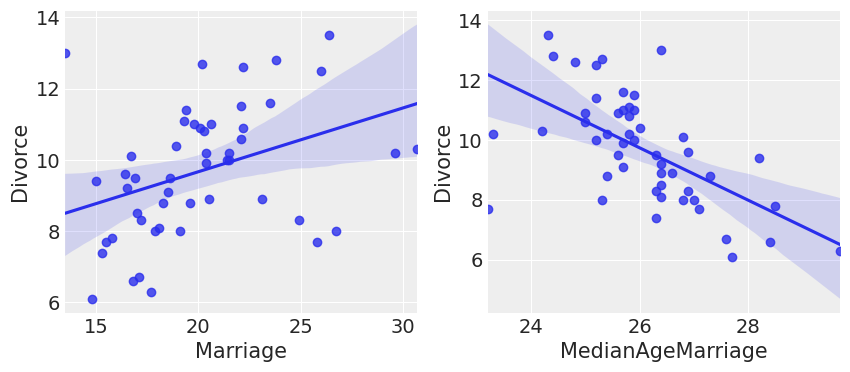

In [4]:
fig, ax = plt.subplots(1,2, figsize=(10,4))
sns.regplot(A, D, data=data, ax=ax[1])
sns.regplot(M, D, data=data, ax=ax[0]);

# A doesn't cause D and so does M. They are just associations.
High age at marriage ~> less divorce? High marriage rate ~> more divorce ??  
Why not use bivariate?

Let's normalize the data

In [5]:
scalers = dict()
for col in [A,M,D]:
    data[col + "_origin"] = data[col]
    scalers[col] = StandardScaler(copy=False).fit(data[[col]])
    data[col] = scalers[col].transform(data[[col + "_origin"]])

## Simple regression
Let's Regress D on A
$$\begin{align}
D_i &∼ \text{Normal}( µ_i , σ) \\
µ_i &= α + β_AA_i \\
α &∼ \text{Normal}(0, 0.2)\\
β_A &∼ \text{Normal}(0, 0.5)\\
σ &∼ \text{Exponential}(1)
\end{align}$$

In [6]:
def quap(model, rng=0, svi_len=1000, **kwargs):
    guide = AutoLaplaceApproximation(model)
    svi = SVI(model, guide, Adam(1), AutoContinuousELBO(), **kwargs)
    init_state = svi.init(PRNGKey(rng))
    state, loss = lax.scan(lambda x, i: svi.update(x), init_state, np.zeros(svi_len))
    param = svi.get_params(state)
    return guide, param

def prior_predictive(guide):
    kwargs = list(guide._kwargs.keys())
    seq = {kwargs[0]:np.array([-2, 2])}
    predictor = Predictive(guide.model, num_samples=20, return_sites=['mu'])
    prior_pred = predictor.get_samples(PRNGKey(1), **seq)
    plt.subplot(xlim=(-2, 2), ylim=(-2, 2))
    for i in range(20):
        plt.plot([-2, 2], prior_pred['mu'][i], "k", alpha=0.4)
    plt.title('Prior predictive on mu')
    plt.xlabel(eval(kwargs[0]))
    plt.ylabel(eval(kwargs[1]))
    
def posterior_predictive(guide, param):
    kwargs = list(guide._kwargs.keys())
    keys = [eval(x) for x in kwargs]
    seq = {kwargs[0]:np.linspace(start=-3, stop=3.2, num=30)}
    post = guide.sample_posterior(PRNGKey(1), param, (500,))
    predictor = Predictive(guide.model, post, return_sites=['mu','D'])
    post_pred = predictor.get_samples(PRNGKey(1), **seq)

    mu_mean = np.mean(post_pred['mu'], 0)
    mu_PI = np.percentile(post_pred['mu'], q=(5.5, 94.5), axis=0)
    D_PI = np.percentile(post_pred['D'], q=(5.5, 94.5), axis=0)
    az.plot_pair(data[keys].to_dict(orient="list"))
    plt.plot(seq[kwargs[0]], mu_mean, "b")
    plt.fill_between(seq[kwargs[0]], mu_PI[0], mu_PI[1], color="b", alpha=0.4)
    plt.fill_between(seq[kwargs[0]], D_PI[0], D_PI[1], color="k", alpha=0.2)
    plt.title('Posterior predictive')
    
def precis(guide, param, prob=0.9):
    s = diag.summary(guide.sample_posterior(PRNGKey(1), param, (1000,)), prob, False)
    return pd.DataFrame(s).T

In [7]:
def model(A, D=None):
    # priors
    a = numpyro.sample('a', dist.Normal(0, 0.2))
    bA = numpyro.sample('bA', dist.Normal(0, 0.5))
    sigma = numpyro.sample('sigma', dist.Exponential(1))
    mu = a + bA*A
    numpyro.deterministic('mu', mu)
    numpyro.sample('D', dist.Normal(mu, sigma), obs=D)

In [8]:
guide1, param1 = quap(model, A=data[A].values, D=data[D].values)

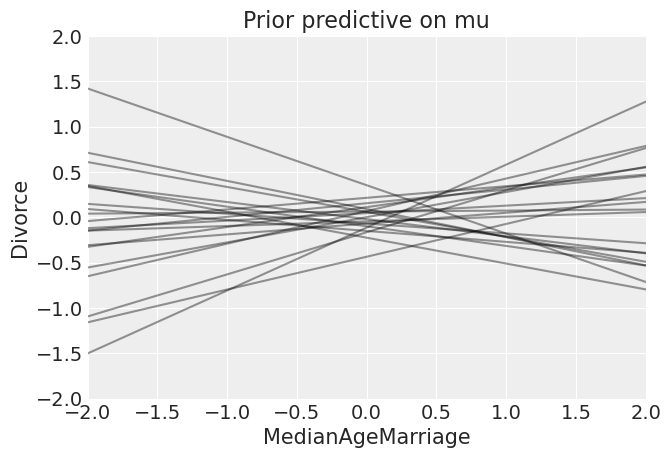

In [9]:
prior_predictive(guide1)

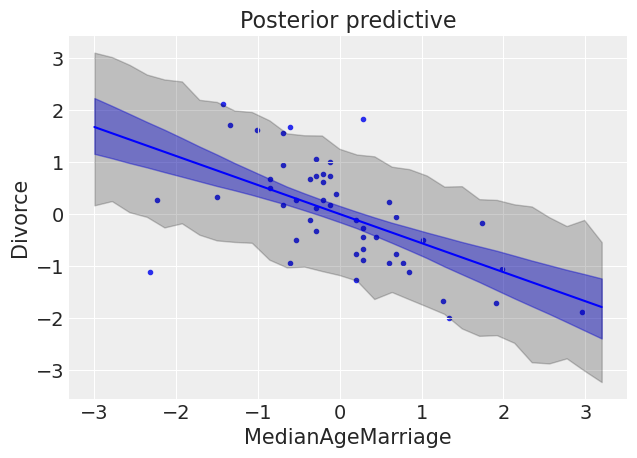

In [10]:
posterior_predictive(guide1, param1)

In [11]:
res1 = precis(guide1, param1)
res1

,mean,std,median,5.0%,95.0%,n_eff,r_hat
a,0.006597,0.100118,0.009893,-0.156961,0.172092,931.501102,0.999858
bA,-0.569216,0.112940,-0.570478,-0.744817,-0.374150,1111.409101,0.999209
sigma,0.809523,0.082124,0.805132,0.668838,0.940068,955.481535,0.999004


### Let's Regress D on M
$$\begin{align}
D_i &∼ \text{Normal}( µ_i , σ) \\
µ_i &= α + β_MM_i \\
α &∼ \text{Normal}(0, 0.2)\\
β_M &∼ \text{Normal}(0, 0.5)\\
σ &∼ \text{Exponential}(1)
\end{align}$$

In [12]:
def model(M, D=None):
    # priors
    a = numpyro.sample('a', dist.Normal(0, 0.2))
    bM = numpyro.sample('bM', dist.Normal(0, 0.5))
    sigma = numpyro.sample('sigma', dist.Exponential(1))
    mu = a + bM*M
    numpyro.deterministic('mu', mu)
    numpyro.sample('D', dist.Normal(mu, sigma), obs=D)
    
guide2, param2 = quap(model, M=data[M].values, D=data[D].values)

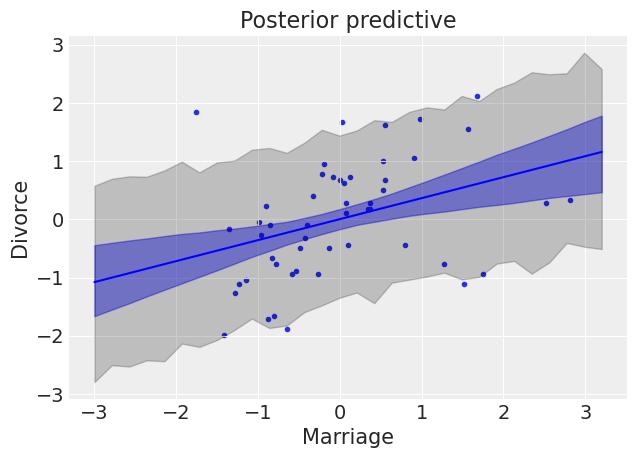

In [13]:
posterior_predictive(guide2, param2)

In [14]:
res2 = precis(guide2, param2)
res2

,mean,std,median,5.0%,95.0%,n_eff,r_hat
a,0.007325,0.111162,0.010984,-0.174275,0.191076,931.501102,0.999858
bM,0.348067,0.129264,0.346622,0.147085,0.571327,1111.409200,0.999209
sigma,0.934762,0.094578,0.931368,0.788135,1.101903,944.548210,0.999001


# Before using multivariate, let's think about some causal relationships
Higher age at marriage may cause less divorce, less marriage.  
And less marriage may cause less divorce, or age affects both so that they're positively correlated?  
Consider 2 possible DAGs:

P(A)P(M|A)P(D|A,M)
[]


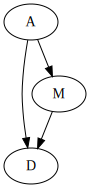

In [15]:
g = CGM(
    nodes=["A", "D", "M"],
    edges=[("A", "D"),
           ("A", "M"),
           ("M", "D")]
)

print(g.get_distribution())
print(g.get_all_independence_relationships())
g.draw()

P(A)P(M|A)P(D|A)
[('D', 'M', {'A'})]


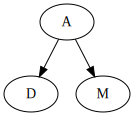

In [16]:
g2 = CGM(
    nodes=["A", "D", "M"],
    edges=[("A", "D"),
           ("A", "M")]
)

print(g2.get_distribution())
print(g2.get_all_independence_relationships())
g2.draw()

The Above states that D is independence of M, conditioning on A.

# Is there a real effect from M to D?
The only difference between 2 DAGs is the independence relationship D_||_M | A.  
We need a model to be able to condition on A.  
That is multivariate. It's useful to question about addition value from a new predictor. **(measure the effect from M to D)**

# Let's begin multivariate regression
Model:

$$\begin{align}
D_i     &∼ \text{Normal}(\mu_i, \sigma)        &&[\text{probability of data]}\\
\mu_i   &= \alpha + \beta_M M_i + \beta_A A_i  &&[\text{linear model]}\\
\alpha  &∼ \text{Normal}(0, 0.2)               &&[\text{prior for } \alpha ] \\
\beta_M &∼ \text{Normal}(0, 0.5)               &&[\text{prior for } \beta_M ] \\
\beta_A &∼ \text{Normal}(0, 0.5)               &&[\text{prior for } \beta_A ] \\
\sigma  &∼ \text{Exponential}(1)               &&[\text{prior for } \sigma ] \\
\end{align}$$

In [17]:
def model(M,A, D=None):
    a = numpyro.sample("a", dist.Normal(0, 0.2))
    bM = numpyro.sample("bM", dist.Normal(0, 0.5))
    bA = numpyro.sample("bA", dist.Normal(0, 0.5))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    mu = a + bM * M + bA * A
    numpyro.deterministic("mu", mu)
    numpyro.sample("D", dist.Normal(mu, sigma), obs=D)

In [18]:
guide3, param3 = quap(model, 
                      M=data[M].values,
                      A=data[A].values,
                      D=data[D].values)

In [19]:
res3 = precis(guide3, param3)
res3

,mean,std,median,5.0%,95.0%,n_eff,r_hat
a,-0.001716,0.096311,-0.006483,-0.158421,0.145649,1049.963320,0.999175
bA,-0.586018,0.155288,-0.586427,-0.847761,-0.337257,822.381926,0.999168
bM,-0.080124,0.159184,-0.081825,-0.349015,0.169887,985.625538,0.999053
sigma,0.798758,0.077034,0.798205,0.676374,0.925334,986.273929,0.999029


Compare to 2 models above, bA is unchanged, bM is closer to Zero. Let's visualise.

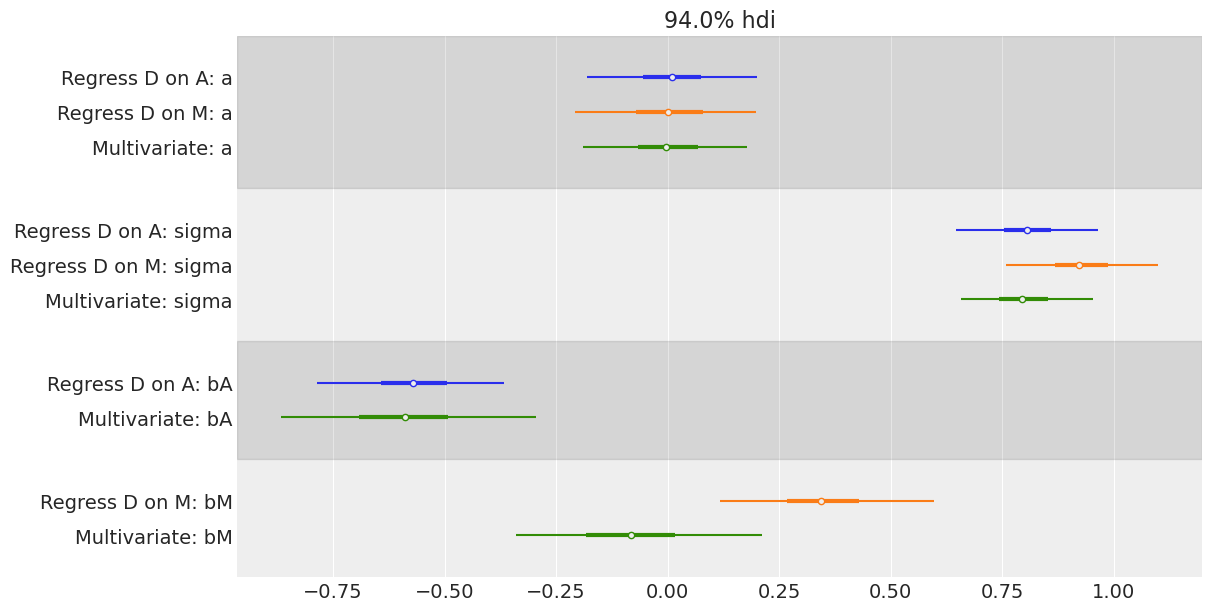

In [20]:
coeftab = {"Regress D on A": guide1.sample_posterior(PRNGKey(1), param1, (1000,)),
           "Regress D on M": guide2.sample_posterior(PRNGKey(2), param2, (1000,)),
           "Multivariate": guide3.sample_posterior(PRNGKey(3), param3, (1000,))}
az.plot_forest(list(coeftab.values()),
              figsize=(12,6),
              model_names=list(coeftab.keys()),
              var_names=['a','sigma','bA','bM']);

Notice `bA` doesn't change at all, and `bM` move backward to zero. `a`,`sigma` is still there.

### That means:
Once we know median age at marriage, there is **little or no additional predictive power** in also knowing the marriage rate.  
Or:  
`D_||_M | A`  
Or:  
DAG 2 is correct!

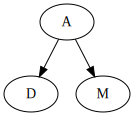

In [21]:
g2.draw()

IF u don't know `A`, then `M` can be a predictor (with simple regression earlier). But it is not **causal**.

---

## That is from numerical analysis, how about visualize this result?

### We will use a residual plot.

In [22]:
def resid_plot(data, order):
    order = [eval(x) for x in order]
    fig, ax = plt.subplots(1,2, figsize=(12,6))
    
    sns.regplot(order[0], order[1], data, ci=None,ax=ax[0],
                scatter_kws={"s":30, "color":"w", "edgecolor":'b'})
    model1 = OLS()
    model1.fit(data[[order[0]]], data[[order[1]]])
    pred = model1.predict(data[[order[0]]])
    resid =  (data[[order[1]]] - pred)[order[1]]
    resid.name = f"{order[1]} Residuals"
    ax[0].set_xlim(data[order[0]].min()-0.2, data[order[0]].max()+0.2)
    ax[0].vlines(data[order[0]],
                 ymin=pred,
                 ymax=data[order[1]],
                 linewidth=0.5)
    sns.regplot(resid, data[order[2]], ax=ax[1],
                scatter_kws={"s":30, "color":"w", "edgecolor":'b'})
    m1,m2 = ax[1].get_ylim()
    ax[1].vlines(0, m1,m2, linestyles='dashed')

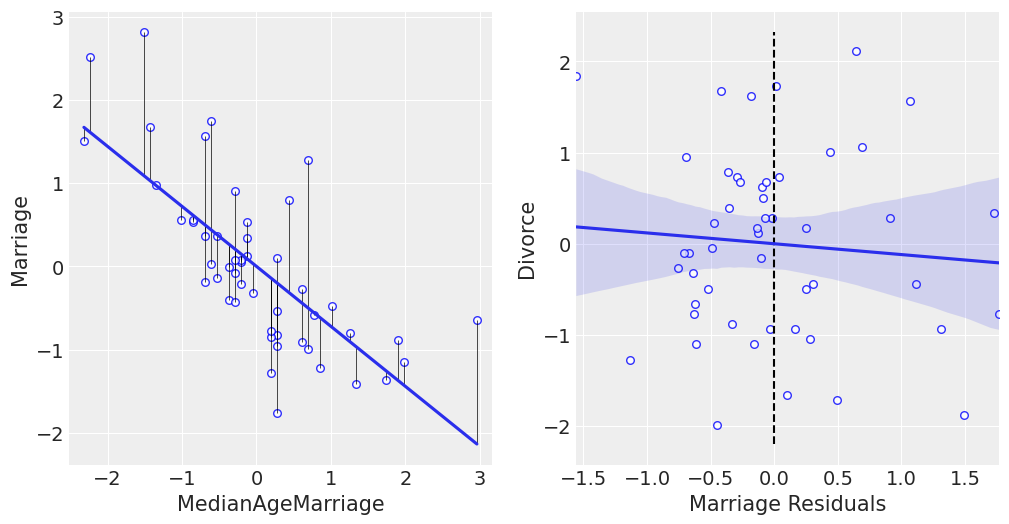

In [23]:
resid_plot(data,"AMD")

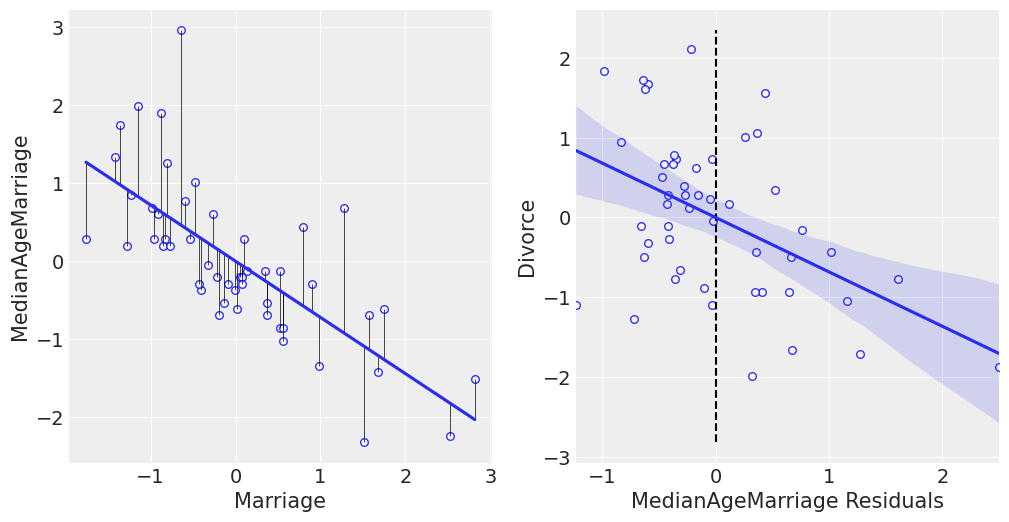

In [24]:
resid_plot(data,"MAD")

Left plot shows the relationship between two vars and its residuals.  
Right plot Use the residual to regress the outcome.  

It means that after we exclude the effect from the first var, how much is the effect from the second var to outcome.  

It shows that `Marriage Residuals` doesn't have much effect because, `Divorce` is so sparse.  
On the contrary, `MedianAgeMarriage Residuals` have negative association with `Divorce`, means the older-to-married people have less divorce.

### We can use a posterior prediction plot to check accuracy.

In [99]:
def posterior_prediction_plot(guide, param, data, rng=1, prob=0.89, **kwargs):
    post = guide.sample_posterior(PRNGKey(rng), param, (1000,))
    post_pred = Predictive(guide.model, post).get_samples(
        PRNGKey(rng+1), **kwargs)
    
    mu = post_pred["mu"]
    mu_mean = np.mean(mu, 0)
    r = (1 - prob)/2
    mu_PI = np.quantile(mu, q=(r, prob+r), axis=0)

    D_sim = post_pred["D"]
    D_PI = np.quantile(D_sim, q=(r, prob+r), axis=0)
    plt.plot(data[D], mu_mean, "o", ms=5, mfc='w', mec='b')
    x = np.array([data[D].min(), data[D].max()])
    plt.plot(x, x, "--")
    plt.vlines(data[D], ymin=mu_PI[0], ymax=mu_PI[1], color='b', alpha=0.6)
    plt.vlines(data[D], ymin=D_PI[0], ymax=D_PI[1], color='b', alpha=0.3, linestyles='dotted')
    plt.xlabel("Observed divorce")
    plt.ylabel("Predicted divorce")

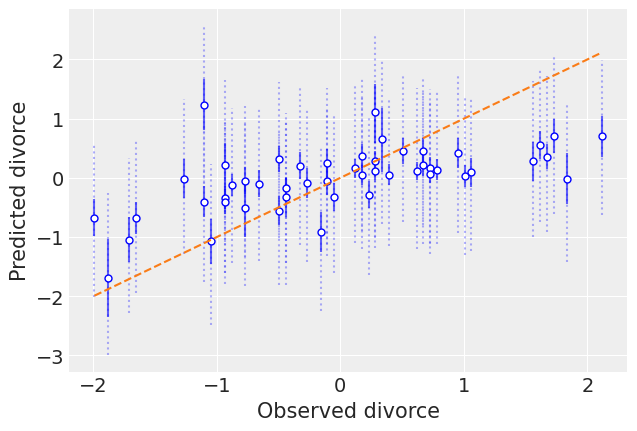

In [100]:
posterior_prediction_plot(guide3, param3, data, M=data[M].values, A=data[A].values)

By looking at posterior prediction plot, we can:
- Check if the model correctly predicts the train data.
- How much noise in each case. What does the the problem lie within? How to improve it?

The above plot is exactly what regression does, *regress toward the mean*. That's why extreme cases are not predict correctly.

### Counterfactual plot
Consider DAG 1

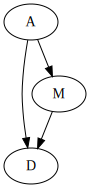

In [102]:
g.draw()

We proved that it's false. But we can assume that it's true, and then control the var M and make it independent of A.

In [118]:
def model(A, M=None, D=None):
    # A -> M
    aM = numpyro.sample("aM", dist.Normal(0, 0.2))
    bAM = numpyro.sample("bAM", dist.Normal(0, 0.5))
    sigma_M = numpyro.sample("sigma_M", dist.Exponential(1))
    mu_M = aM + bAM * A
    M = numpyro.sample("M", dist.Normal(mu_M, sigma_M), obs=M)
    # A -> D <- M
    a = numpyro.sample("a", dist.Normal(0, 0.2))
    bM = numpyro.sample("bM", dist.Normal(0, 0.5))
    bA = numpyro.sample("bA", dist.Normal(0, 0.5))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    mu = a + bM * M + bA * A
    numpyro.sample("D", dist.Normal(mu, sigma), obs=D)

guide3_A = AutoLaplaceApproximation(model)
svi = SVI(model, guide3_A, Adam(1), AutoContinuousELBO(),
          A=data[A].values, M=data[M].values, D=data[D].values)
init_state = svi.init(PRNGKey(0))
state, loss = lax.scan(lambda x, i: svi.update(x), init_state, np.zeros(1000))
param3_A = svi.get_params(state)

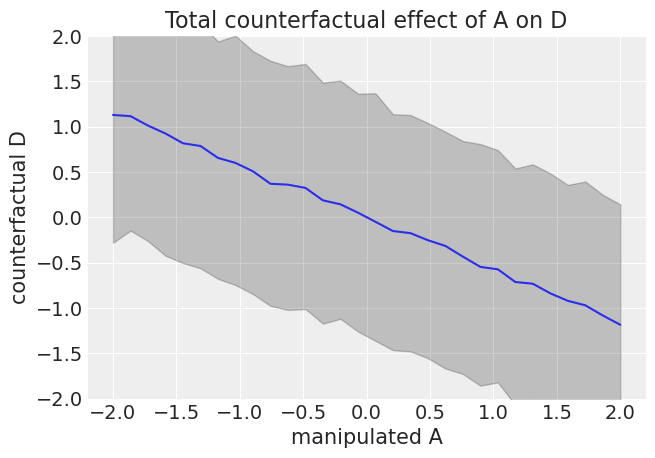

In [121]:
A_seq = np.linspace(-2, 2, num=30)
sim_dat = dict(A=A_seq)
# simulate M and then D, using A_seq
post = guide3_A.sample_posterior(PRNGKey(1), param3_A, (1000,))
s = Predictive(guide3_A.model, post).get_samples(PRNGKey(2), **sim_dat)
plt.plot(sim_dat["A"], np.mean(s["D"], 0))
plt.gca().set(ylim=(-2, 2), xlabel="manipulated A", ylabel="counterfactual D")
plt.fill_between(sim_dat["A"], *np.percentile(s["D"], q=(5.5, 94.5), axis=0),
                 color="k", alpha=0.2)
plt.title("Total counterfactual effect of A on D");

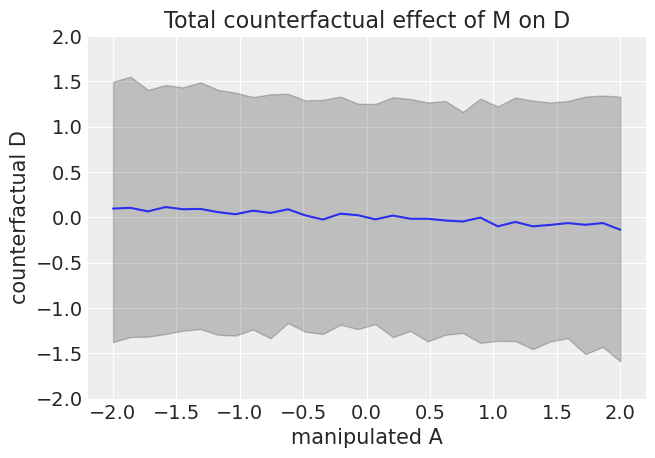

In [124]:
sim_dat = dict(M=np.linspace(-2, 2, num=30), A=0)
s = Predictive(guide3_A.model, post).get_samples(PRNGKey(2), **sim_dat)["D"]

plt.plot(sim_dat["M"], np.mean(s, 0))
plt.gca().set(ylim=(-2, 2), xlabel="manipulated A", ylabel="counterfactual D")
plt.fill_between(sim_dat["M"], *np.percentile(s, q=(5.5, 94.5), axis=0),
                 color="k", alpha=0.2)
plt.title("Total counterfactual effect of M on D");

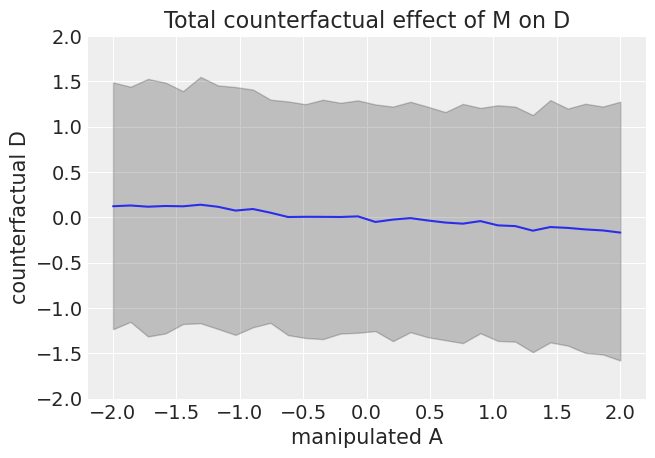

In [115]:
sim_dat = dict(M=np.linspace(-2, 2, num=30), A=0)
post = guide3.sample_posterior(PRNGKey(1), param3, (1000,))
s = Predictive(guide3.model, post).get_samples(PRNGKey(2), **sim_dat)["D"]

plt.plot(sim_dat["M"], np.mean(s, 0))
plt.gca().set(ylim=(-2, 2), xlabel="manipulated A", ylabel="counterfactual D")
plt.fill_between(sim_dat["M"], *np.percentile(s, q=(5.5, 94.5), axis=0),
                 color="k", alpha=0.2)
plt.title("Total counterfactual effect of M on D");